In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def sub_vth(w_l,vgs,vth,temp=300):
    """
    Helper function to calculate sub-vth current analytically.

    Uses randomized parameters to mimic
    measurement noise and manufacturing/material variability
    """
    # Electron charge
    q = 1.60218e-19
    # Boltzman constant
    k = 1.3806e-23
    # Capacitance factor (randomized to mimic manufacturing variability)
    eta = 1.2+0.01*np.random.normal()
    # Mobility factor/coefficient (randomized to mimic material and manufacturing variability)
    w_l = w_l*(1+0.01*np.random.normal())

    return w_l*np.exp(q*(vgs-vth)/(eta*k*temp))

In [ ]:
class MOSFET:
    def __init__(self,params=None,terminals=None):

        # Params
        if params is None:
            self._params_ = {'BV':20,
                             'Vth':1.0,
                             'gm':1e-2}
        else:
            self._params_ = params

        # Terminals
        if terminals is None:
            self._terminals_ = {'source':0.0,
                        'drain':0.0,
                        'gate':0.0}
        else:
            self._terminals_ = terminals

        # Determine state
        self._state_ = self.determine_state()

        # Leakage model trained?
        self._leakage_ = False
        self.leakage_model = None

    def __repr__(self):
        return "Digital Twin of a MOSFET"

    def determine_state(self,vgs=None):
        """
        """
        if vgs is None:
            vgs = self._terminals_['gate'] - self._terminals_['source']
        else:
            vgs = vgs
        if vgs > self._params_['Vth']:
            return 'ON'
        else:
            return 'OFF'

    def id_vd(self,vgs=None,vds=None,rounding=True):
        """
        Calculates drain-source current from terminal voltages and gm
        """
        if vds is None:
            vds = self._terminals_['drain'] - self._terminals_['source']
        else:
            vds = vds
        if vgs is None:
            vgs = self._terminals_['gate'] - self._terminals_['source']
        else:
            vgs = vgs

        vth = self._params_['Vth']
        state = self.determine_state(vgs=vgs)
        self._state_ = state

        if state=='ON':
            if vds <= vgs - vth:
                ids = self._params_['gm']*(vgs - vth - (vds/2))*vds
            else:
                ids = (self._params_['gm']/2)*(vgs-vth)**2
            if rounding:
                return round(ids,3)
            else:
                return ids
        else:
            return sub_vth(w_l=self._params_['gm'],
                           vgs=vgs,
                           vth=vth)
            #return 0.0

    def rdson(self,vgs=None,vds=None):
        """
        Calculates Rdson i.e. on-state resistance of the MOSFET
        """
        if vds is None:
            vds = self._terminals_['drain'] - self._terminals_['source']
        else:
            vds = vds
        if vgs is None:
            vgs = self._terminals_['gate'] - self._terminals_['source']
        else:
            vgs = vgs

        ids = self.id_vd(vgs=vgs,vds=vds,rounding=False)
        vds_delta = vds+0.001
        ids_delta = self.id_vd(vgs=vgs,vds=vds_delta,rounding=False)
        rdson = 0.001/(ids_delta-ids)

        return round(rdson,3)

    def train_leakage(self,data=None,
                      batch_size=5,
                      epochs=20,
                      learning_rate=2e-5,
                      verbose=1):
        """
        Trains the digital twin for leakage current model with experimental data
        Args:
            data: The training data, expected as a Pandas DataFrame
            batch_size (int): Training batch size
            epochs (int): Number of epochs for training
            learning_rate (float): Learning rate for training
            verbose (0 or 1): Verbosity of display while training
        """
        if data is None:
            return "No data to train with"
        X_train_scaled, X_test_scaled, \
        y_train_scaled, y_test_scaled = prepare_data(data,
                                             input_cols=['w_l','vgs','vth'],
                                             output_var='log-leakage',
                                                     scaley=False)
        # Deep-learning model
        model = build_model(num_layers=3,
                            architecture=[32,32,32],
                            input_dim=3)
        # Compile and train
        model_trained = compile_train_model(model,
                                            X_train_scaled,
                                            y_train_scaled,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            learning_rate=learning_rate,
                                            verbose=verbose)
        self.leakage_model = model_trained
        self._leakage_ = True

    def leakage(self,
                w_l=1e-2,
                vgs=None,
                vth=None):
        """
        Calculates leakage current using the deep learning model
        """
        if not self._leakage_:
            return "Leakage model is not trained yet"
        # Vgs
        if vgs is None:
            vgs = self._terminals_['gate'] - self._terminals_['source']
        else:
            vgs = vgs
        # Vth
        if vth is None:
            vth = self._params_['Vth']
        else:
            vth = vth
        # Predict
        x = np.array([w_l,vgs,vth])
        ip = x.reshape(-1,3)
        result = float(10**(-self.leakage_model.predict(ip)))

        return result


        mosfet = MOSFET()
        mosfet

## A `MOSFET` object

In [ ]:
mosfet._params_

{'BV': 20, 'Vth': 1.0, 'gm': 0.01}

## Object state changes as terminal voltage assignment varies

In [ ]:
mosfet = MOSFET(terminals={'source':0.0,
            'drain':0.0,
            'gate':2.0},
           params={'BV':20,
                   'Vth':1.0,
                   'gm':1e-2})

In [ ]:
mosfet._state_

'ON'

In [ ]:
mosfet = MOSFET(terminals={'source':0.0,
            'drain':0.0,
            'gate':2.0},
            params={'BV':20,
                   'Vth':1.0,
                   'gm':1e-2})

In [ ]:
mosfet._state_

'ON'

## Id-Vd

In [ ]:
mosfet.id_vd(vgs=0.2,vds=2.0)

6.310890943747286e-14

In [ ]:
mosfet.id_vd(vgs=3.0,vds=0.5)

0.009

In [ ]:
mosfet.id_vd(vgs=3.0,vds=1.0)

0.015

In [ ]:
mosfet.id_vd(vgs=3.0,vds=3.0)

0.02

In [ ]:
mosfet.id_vd(vgs=3.0,vds=4.0)

0.02

In [ ]:
mosfet._state_

'ON'

In [ ]:
mosfet.rdson(vgs=3.0,vds=0.5)

66.689

In [ ]:
mosfet.rdson(vgs=3.0,vds=0.6)

71.454

In [ ]:
mosfet.rdson(vgs=5.0,vds=1.5)

40.008

In [ ]:
ids = []
mosfet = MOSFET()
vds_vals = [0.01*i for i in range(1,501)]
for v in vds_vals:
    ids.append(mosfet.id_vd(vgs=3.0,vds=v,rounding=False))

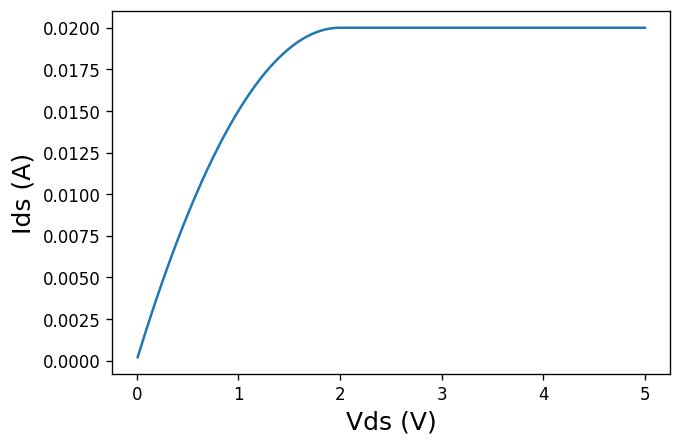

In [ ]:
plt.figure(dpi=120)
plt.plot(vds_vals,ids)
plt.xlabel("Vds (V)",fontsize=15)
plt.ylabel("Ids (A)",fontsize=15)
plt.show()

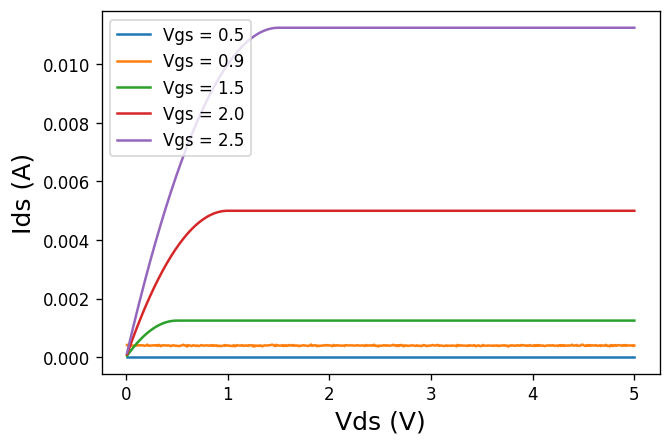

In [ ]:
m = MOSFET()
plt.figure(dpi=120)
for vgs in [0.5,0.9,1.5,2.0,2.5]:
    ids = []
    vds_vals = [0.01*i for i in range(1,501)]
    for v in vds_vals:
        ids.append(m.id_vd(vgs=vgs,vds=v,rounding=False))
    plt.plot(vds_vals,ids)
plt.legend(["Vgs = "+str(v) for v in [0.5,0.9,1.5,2.0,2.5]])
plt.xlabel("Vds (V)",fontsize=15)
plt.ylabel("Ids (A)",fontsize=15)
plt.show()

## Sub-Vth leakage

In [ ]:
m.train_leakage()

'No data to train with'

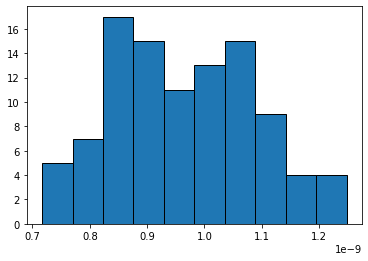

In [ ]:
sub = []
for i in range(100):
    sub.append(sub_vth(w_l=1e-2,vgs=0.5,vth=1.0))

plt.hist(sub,edgecolor='k')
plt.show()

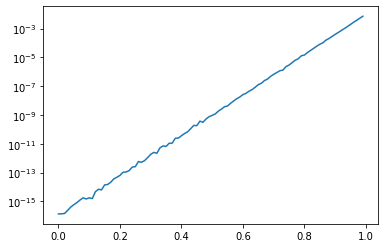

In [ ]:
sub = []
vgs = []
for i in range(100):
    sub.append(sub_vth(w_l=1e-2,vgs=i*0.01,vth=1.0))
    vgs.append(i*0.01)

plt.semilogy(vgs,sub)
plt.show()

### Synthetic leakage data

In [ ]:
from itertools import product

In [ ]:
w_l_list = [1e-3*i for i in range(1,21)]
vgs_list = [0.01*i for i in range(1,91)]
vth_list = [0.05*i for i in range(21,31)]

In [ ]:
comb = list(product(w_l_list,vgs_list,vth_list))

In [ ]:
data_dict = {'w_l':[],'vgs':[],'vth':[],'sub-vth':[]}
for c in comb:
    data_dict['w_l'].append(c[0])
    data_dict['vgs'].append(c[1])
    data_dict['vth'].append(c[2])
    data_dict['sub-vth'].append(sub_vth(c[0],c[1],c[2]))

In [ ]:
import pandas as pd
df = pd.DataFrame(data=data_dict,columns=['w_l','vgs','vth','sub-vth'])

In [ ]:
df.sample(7).T

,8006,11903,1405,11179,8868,5612,12001
w_l,9.000000e-03,1.400000e-02,2.000000e-03,1.300000e-02,1.000000e-02,7.000000e-03,1.400000e-02
vgs,8.100000e-01,2.100000e-01,5.100000e-01,3.800000e-01,7.700000e-01,2.200000e-01,3.100000e-01
vth,1.350000e+00,1.200000e+00,1.300000e+00,1.500000e+00,1.450000e+00,1.150000e+00,1.100000e+00
sub-vth,2.684582e-10,1.504563e-16,1.578615e-14,2.455066e-18,2.321042e-12,6.176563e-16,1.165271e-13


In [ ]:
df['log-leakage'] = -np.log10(df['sub-vth'])

## Training leakage model

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def prepare_data(df, input_cols,output_var,test_size=0.3,scaley=False):
    """
    """
    df1 = df.copy()
    X = df1[input_cols]
    y = df1[str(output_var)]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Min-max scaler from Scikit-learn
    scalerx = MinMaxScaler()
    scalery = MinMaxScaler()
    X_train_scaled = scalerx.fit_transform(X_train)
    X_test_scaled = scalerx.fit_transform(X_test)
    if scaley == True:
        y_train_scaled = scalery.fit_transform(y_train.values.reshape(-1, 1))
        y_test_scaled = scalery.fit_transform(y_test.values.reshape(-1, 1))
    else:
        y_train_scaled = y_train.values.reshape(-1, 1)
        y_test_scaled = y_test.values.reshape(-1, 1)

    return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)


def build_model(num_layers=1, architecture=[32],act_func='relu',
                input_dim=2, output_class=10):
  """
  Builds a densely connected neural network model from user input
  num_layers: Number of hidden layers
  architecture: Architecture of the hidden layers (densely connected)
  act_func: Activation function. Could be 'relu', 'sigmoid', or 'tanh'.
  input_shape: Dimension of the input vector
  output_class: Number of classes in the output vector
  """
  layers=[tf.keras.layers.Dense(input_dim,input_dim=input_dim)]
  if act_func=='relu':
    activation=tf.nn.relu
  elif act_func=='sigmoid':
    activation=tf.nn.sigmoid
  elif act_func=='tanh':
    activation=tf.nn.tanh

  for i in range(num_layers):
    layers.append(tf.keras.layers.Dense(architecture[i], activation=tf.nn.relu))
  layers.append(tf.keras.layers.Dense(1))

  model = tf.keras.models.Sequential(layers)
  return model


def compile_train_model(model,x_train, y_train, callbacks=None,
                        learning_rate=0.001,batch_size=1,epochs=10,verbose=0):
  """
  Compiles and trains a given Keras model with the given data.
  Assumes Adam optimizer for this implementation.

  learning_rate: Learning rate for the optimizer Adam
  batch_size: Batch size for the mini-batch optimization
  epochs: Number of epochs to train
  verbose: Verbosity of the training process
  """

  model_copy = model
  model_copy.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                     loss="mse", metrics=["mse"])

  if callbacks is not None:
        model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                 callbacks=[callbacks],verbose=verbose)
  else:
    model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                   verbose=verbose)
  return model_copy

mosfet.train_leakage(df)

Epoch 1/20
2520/2520 [==============================] - 6s 2ms/step - loss: 7.6196 - mse: 7.6196
Epoch 2/20
2520/2520 [==============================] - 6s 2ms/step - loss: 0.0169 - mse: 0.0169
Epoch 3/20
2520/2520 [==============================] - 5s 2ms/step - loss: 0.0206 - mse: 0.0206
Epoch 4/20
2520/2520 [==============================] - 5s 2ms/step - loss: 0.0196 - mse: 0.0196
Epoch 5/20
2520/2520 [==============================] - 5s 2ms/step - loss: 0.0185 - mse: 0.0185
Epoch 6/20
2520/2520 [==============================] - 5s 2ms/step - loss: 0.0194 - mse: 0.0194
Epoch 7/20
2520/2520 [==============================] - 6s 2ms/step - loss: 0.0199 - mse: 0.0199
Epoch 8/20
2520/2520 [==============================] - 5s 2ms/step - loss: 0.0193 - mse: 0.0193
Epoch 9/20
2520/2520 [==============================] - 5s 2ms/step - loss: 0.0191 - mse: 0.0191
Epoch 10/20
2520/2520 [==============================] - 5s 2ms/step - loss: 0.0187 - mse: 0.0187
Epoch 11/20
2520/2520 [======

In [ ]:
m1_trained = mosfet.leakage_model

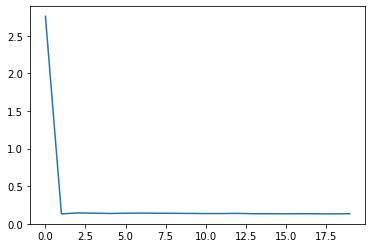

In [ ]:
plt.plot(np.sqrt(m1_trained.history.history['mse']))
plt.show()

In [ ]:
mosfet.leakage()

1/1 [==============================] - 0s 89ms/step


9.405688166639408e-25

In [ ]:
mosfet.leakage(w_l=1e-1,vgs=0.75)

1/1 [==============================] - 0s 30ms/step


7.55001462282405e-15

In [ ]:
mosfet._terminals_['gate']=0.8

In [ ]:
mosfet.leakage(w_l=1)

1/1 [==============================] - 0s 30ms/step


2.097541568603714e-13

1/1 [==============================] - 0s 25ms/step


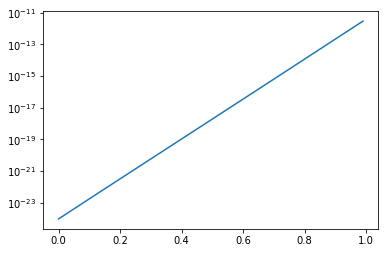

In [ ]:
sub = []
vgs = []
for i in range(100):
    sub.append(mosfet.leakage(w_l=1e-2,vgs=i*0.01,vth=1.0))
    vgs.append(i*0.01)

plt.semilogy(vgs,sub)
plt.show()

In [ ]:
mosfet = MOSFET(terminals={'source':0.0,
            'drain':0.0,
            'gate':2.0})

In [ ]:
%%capture
mosfet.leakage()

In [ ]:
####### Analytical model for Switching losss Novelty #######
import math

# Define MOSFET parameters
Vds = 100 # Drain-to-Source Voltage (V)
Vgs = 10 # Gate-to-Source Voltage (V)
Id = 5 # Drain Current (A)
Vth = 4 # Threshold Voltage (V)
Coss = 1000e-12 # Output Capacitance (F)
Rg = 50 # Gate Resistance (ohms)
Ton = 50e-9 # Turn-On Time (s)
Toff = 100e-9 # Turn-Off Time (s)
Fsw = 100e3 # Switching Frequency (Hz)

# Calculate the switching loss
Qg = Coss * Vgs # Gate Charge (C)
Eon = 0.5 * Qg * Vgs # Turn-On Energy (J)
Eoff = 0.5 * Qg * Vds # Turn-Off Energy (J)
Psw = (Eon + Eoff) * Fsw # Switching Loss (W)

# Print the results
print("Switching Loss = %.2f W" % Psw)


Switching Loss = 0.06 W
